# 100 Historical Spanish newspaper editions

**Henning, M. S...; Ianovitskii, M. S....; Raulli, L. S5352029; Uribe Silva, M.P. S...**

## Introduction and Background 

Newspapers are the tangible record of the history lived by a society, and their importance lies in the way they observe, describe and record the facts. How do they record reality? How have editorial lines and political trends marked these records? Can we observe these changes of records and trends through a distant observation analysis? Our project wants to provide a dataset of historical Spanish newspaper editions. This dataset should be suitable for tackling our underlying question: **What influences newspaper style?** (the question will be properly adressed in the final Tool and Methods project.)

The project focuses on Spain because we wanted to work with a non-English dataset. There is a strong focus within the Digital Humanities on English data - understandably, since it is an international field of study. Still, we wanted to provide a different dataset here. The project also focuses on the years 1890 to 1940. This is a subjective selection, but those years were definitely eventful in Spain: The country moved from a monarchy to a monarchy with a dictatorship to a republic, had a civil war, a revolution and then became a dictatorship. We were interested in seeing whether these tumultous events would be visible in newspaper style.

Political change through time is obviously not the only thing that could influence a newspaper edition's style. A language itself changes with **time**, a newspaper's staff as well. All of this would mean that time would be feature we wanted to track for our newspaper editions. Another feature would be their **ideology**: maybe Socialists wrote differently than Conservatives, Anarchists differently from Republicans? Languages are also not monolithic, most have many dialects spoken across a country. Taking this into account, we also wanted to track newspapers' **headquarters** and target **regions**. Another potential feature could be the age of the target **audience**, as there were many papers aimed specifically at young readers. There are also different kinds of newspapers: some are more concerned with breaking the news, others with providing a regular perspective on things. We therefore also track publication **format**. And finally, maybe it was not so much the time that articles were written in, but the time when a newspaper was founded that influenced its style? For this, we also tracked our newspapers' years of **foundation**. 

The features we wanted to track therefore were:
- Ideology
- Headquarters
- Audience
- Region
- Format
- Foundation

We then collected **100 editions** of various newspapers spread out as much as possible along these features. Our data and our metadata come from the Digital Newspaper Library of the National Library of Spain (__[Hemeroteca Digital](https://hemerotecadigital.bne.es/hd/es/advanced)__), where a diversity of newspapers and magazines with different editorial and political lines published from the year 1840 to the year 2022 can be found.

## Tutorial 


### Collecting  the data 

Everything started by manually selecting and downloadind 100 editions according to their features. This selection also took into account the usability of the available data. While useful for our analysis, it is important to keep in mind that this selection is in no way representative. We stored our data in a CSV file.

In [14]:
import pandas as pd
editions = pd.read_csv ('./editions.csv', index_col=0)
editions.head()

,id,newspaper,year,month,day,link
0,1,ahora,1931,4,9,https://hemerotecadigital.bne.es/hd/es/viewer?...
1,2,ahora,1932,4,15,https://hemerotecadigital.bne.es/hd/es/viewer?...
2,3,ahora,1932,9,16,https://hemerotecadigital.bne.es/hd/es/viewer?...
3,4,ahora,1935,1,9,https://hemerotecadigital.bne.es/hd/es/viewer?...
4,5,ahora,1935,11,15,https://hemerotecadigital.bne.es/hd/es/viewer?...


### Managing the data: cleaning the texts and selection of the appropriate corpus

After selecting and downloading the raw texts from the Hemeroteca Digital of the National Library of Spain, the next step was to clean the downloaded texts. Text cleaning is a fundamental step for the development of the dataset and subsequent analysis, therefore, we invested a lot of hours to build a consistent and clean dataset as much as we could to answer our research question. We strongly recommend investing time to clean the raw data to be used for any project in a mindful way.

In general, the scanned texts were in acceptable reading condition when we collect them. There are two problems though: 1. There were extra spaces in some words, and 2. Certain characters were not recognized by the OCR.

Fixing words with extra spaces manually was not an option because of the amount of data, so we decided to create a function that tries to recompose those words, remove the spaces, and put all the tokens in lowercase. To address the OCR issue instead, we decided to work with a Spanish corpus to remove unrecognized text. An important part of the work was therefore to select which corpus we would work with. After evaluating some available corpora in Spanish, we selected two to test in depth:

1. **NLTK "cess_esp"** corpus was created in 2007 and contains 188,650 words of Spanish which have been syntactically annotated within the framework of the CESS-ECE project (Syntactically & Semantically Annotated Corpora, Spanish, Catalan, Basque). The CESS-ESP was annotated using constituents and functions (with AGTK, University of Pennsylvania). Source: __[Universal Catalogue](http://universal.elra.info/product_info.php?cPath=42_43&products_id=1509)__ <br> <br>
2. **SPACY "es_core_news_md** is a free, open-source library for advanced Natural Language Processing (NLP) in Python, it is designed specifically for production use and it helps you build applications that process large volumes of text. During processing, spaCy first tokenizes the text, i.e. segments it into words, punctuation, and so on. This is done by applying rules specific to each language, in our case, we select a Spanish pipeline optimized for CPU. Source: __[Spacy.io](https://spacy.io/models/es)__

But how could we quantitatively evaluate which of the corpora best optimizes our future dataset? We decided to select the corpus which would recognize the highest quantity of words in our dataset. For this purpose, we have created a function that, starting from our full dataset, calculates the percentage of tokens recognized by each corpus, and we selected the one with the highest score.

The main differences between NLTK and spaCy are well described in __[this article](https://www.activestate.com/blog/natural-language-processing-nltk-vs-spacy/)__.

In [ ]:
#Words recognized by each corpus
corpora = {}
words_corpus = {word.lower() for word in nltk.corpus.cess_esp.words()}
corpora["cess_esp"] = {word for word in tokens if word in words_corpus}
doc = spacy_es(" ".join(tokens))
corpora["es_core_news_md"] = {token.text for token in doc if token.has_vector}

#Calculate the percentage of words recognized 
for corpus, tokens_recognized in corpora.items():
    percent_score = len(tokens_recognized)*100/ len(tokens)
    print(f"{corpus} {percent_score}%")

This function can be applied to any corpus, which makes it flexible for future use. The advantages of applying this method are mainly that it is simple, relatively fast, and that it allows us to maximize the amount of useful data we can work with, which gives us the possibility to carry out a more extensive analysis of our dataset. Its disadvantage is that we cannot be sure of the quality of the result, since not necessarily a greater amount of data (in this case, words) is synonymous with a higher data quality. Despite the limits, we believe that it is useful for our project to carry out this evaluation and that this method can be improved over time and adjusted to the demands, needs, and objectives of the project that decides to make use of it. 

In [ ]:
%pip install spacy nltk
!python -m spacy download es_core_news_md
import nltk
import spacy
import os.path
from glob import glob
spacy_es = spacy.load("es_core_news_md")
spacy_es.max_length = 4000000 #Increase the limit of the text that Spacy can work with
nltk.download("punkt") 

#Run this function to read the file
def read_file(filename):
    with open(filename, encoding='utf8') as infile:
        contents = infile.read()
    return contents

#Run this function to recompose the words, remove the spaces, and put tokens in lower letters
def retokenize(tokenized_text):
    tokenized = []
    is_broken_word = False
    temp_word = ""
    for token in tokenized_text:
        token_lower = token.lower()
        if len(token) == 1:
            if not is_broken_word:
                is_broken_word = True
                temp_word = token_lower
            else:
                temp_word += token_lower
        else:
            if is_broken_word:
                tokenized.append(temp_word)
                temp_word = ""
                is_broken_word = False
            tokenized.append(token_lower)
    return tokenized

Up to this point, all the symbols and unrecognized words that come from the OCR are still included in the dataset, so we are going to remove the ones that are not present in the “es_core_news_md” corpus that we selected earlier. This way, we know that we have only valid words. The trade-off is that we lose some words and all phrase structure, which means that we know that our analysis will be not completely accurate and cannot fully rely on context.

In [ ]:
#Run the function to get clean texts
for filename in glob('texts/*.txt'):
    basename = os.path.basename(filename)
    new_name = f'texts_clean/{basename}'
    text = read_file(filename)
    tokenized_text = nltk.tokenize.word_tokenize(text)
    tokenized_text = retokenize(tokenized_text)
    doc = spacy_es(" ".join(tokenized_text))
    clean_texts = [token.text for token in doc if token.has_vector]
    with open(new_name, 'w', encoding = 'utf-8') as fp:
        for item in clean_texts:
            fp.write(f'{item} ')

### Explore, analyse, and visualize the data

As mentioned in the introduction, this dataset was created to perform some analyses using Stylo and Gephi. In order to make the results easier to read, we needed to rename the files according to the analysis they were intended for.

In [ ]:
# Prepare corpora for stylistic analyis

editions = []
for edition in glob('./texts_clean/*.txt'):
    editions.append(edition)
    
def create_subcorpus(feature):
    if not os.path.exists("./stylo/"):
        os.makedirs("./stylo/")
    subcorpus = str("./stylo/" + feature + "/corpus")
    if not os.path.exists(subcorpus):
        os.makedirs(subcorpus)
    for edition in editions:
        edition_id = int(os.path.splitext(basename(edition))[0])
        feature_lookup = str(editions_full.iloc[edition_id-1][feature])
        edition_id = str(edition_id)
        with open(edition, "r", encoding = "utf8") as oldfile, open(subcorpus + "/" + feature_lookup + "_" + edition_id + ".txt", "w", encoding = "utf8") as newfile:
            for line in oldfile:
                newfile.write(line)
        
create_subcorpus("newspaper")
create_subcorpus("ideology")
create_subcorpus("hq")
create_subcorpus("audience")
create_subcorpus("region")
create_subcorpus("format")
create_subcorpus("foundedin")

In view of the factors we selected for our study, we also carried out several sample analyses in order to identify patterns in the development of the Spanish-language press from 1890 to 1940.

In [27]:
# Download libraries useful for data analysis
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup

# Read the csv file into pandas
editions_with_text = pd.read_csv ('./editions_with_text.csv')
df = editions_with_text #To make it easier when calling the DataFrame

At first we have looked at how many editions of various ideology appeared through timescale.

In [28]:
editions_timescale = pd.crosstab(df['newspaper'], df['year'], margins = True)
editions_timescale.head()

year,1890,1891,1892,1893,1894,1895,1896,1898,1899,1900,...,1930,1931,1932,1934,1935,1936,1937,1938,1939,All
newspaper,,,,,,,,,,,,,,,,,,,,,
ahora,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,2,0,2,0,0,7
andalucia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
ceda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,0,0,0,0,4
el amigo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
el cantábrico,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,5


Then we looked at how ideology has evolved over time.

In [29]:
editions_timescale = pd.crosstab(df['ideology'], df['year'], margins = True)
editions_timescale.head()

year,1890,1891,1892,1893,1894,1895,1896,1898,1899,1900,...,1930,1931,1932,1934,1935,1936,1937,1938,1939,All
ideology,,,,,,,,,,,,,,,,,,,,,
anarchist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,1,6
carlist,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,7
conservative,2,2,2,0,0,0,2,0,0,0,...,2,1,2,2,2,0,0,0,0,25
democrat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
federalist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


And defined how many editions of various ideology our dataset contains.

In [30]:
editions_ideology = pd.crosstab(df['newspaper'], df['ideology'], margins = True)
editions_ideology

ideology,anarchist,carlist,conservative,democrat,federalist,liberal,regionalist,republican,socialist,All
newspaper,,,,,,,,,,
ahora,0,0,0,0,0,0,0,0,7,7
andalucia,0,0,0,0,0,0,5,0,0,5
ceda,0,0,4,0,0,0,0,0,0,4
el amigo,0,0,0,0,5,0,0,0,0,5
el cantábrico,0,0,0,0,0,0,0,0,5,5
el cruzado español,0,0,6,0,0,0,0,0,0,6
el imparcial,0,0,0,0,0,7,0,0,0,7
el pais,0,0,0,0,0,0,0,9,0,9
el siglo futuro,0,7,0,0,0,0,0,0,0,7


Here we can observe how many editions per year have been published, the mean, max and min values of editions per years in combined statistics.

In [31]:
df[['year']].describe()

,year
count,100.000000
mean,1917.220000
std,14.977815
min,1890.000000
25%,1905.750000
50%,1918.000000
75%,1931.250000
max,1939.000000


Let's look at which year the most newspapers and magazines were published.

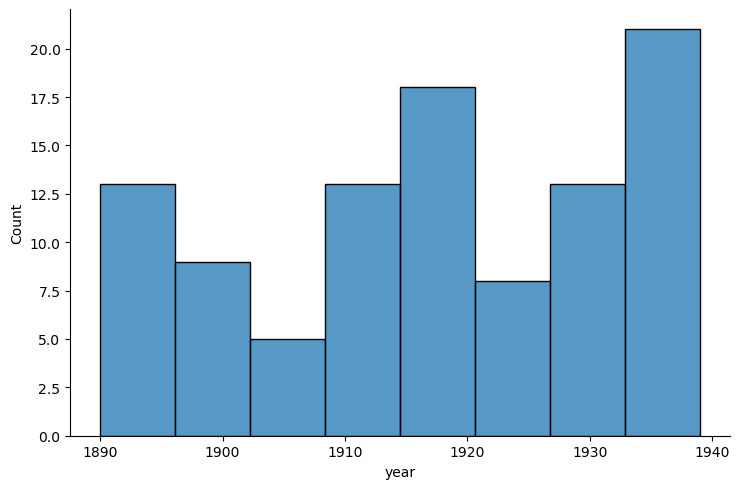

In [32]:
sns.displot(x='year', height=5,aspect=1.5, data=df)

And now we can see the statistics of 'ideology' represented through years.

In [33]:
df_newspaper_by_years = df.groupby('ideology')['year'].sum()
df_newspaper_by_years

ideology
anarchist       11625
carlist         13393
conservative    47860
democrat        11452
federalist       9589
liberal         38324
regionalist      9582
republican      17147
socialist       32750
Name: year, dtype: int64

Further on we examined the evolution of ideology through time shown in various outputs. The first graph illustrates the ratio of the ideology of the publications throughout the time period in question and in each individual period.

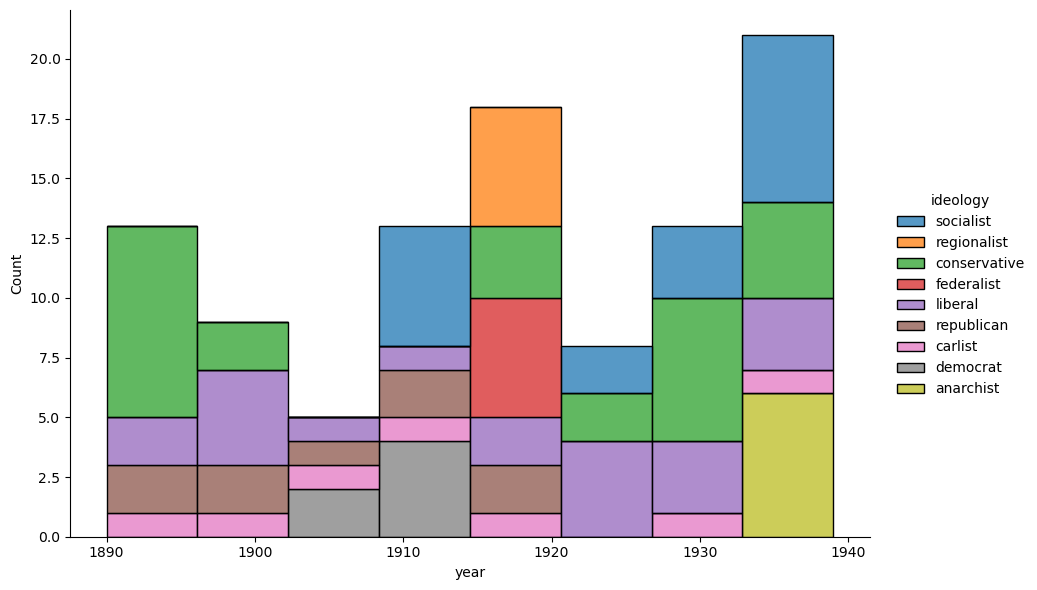

In [34]:
sns.displot(df, x ="year",hue='ideology', height=6,aspect=1.5, multiple='stack') 

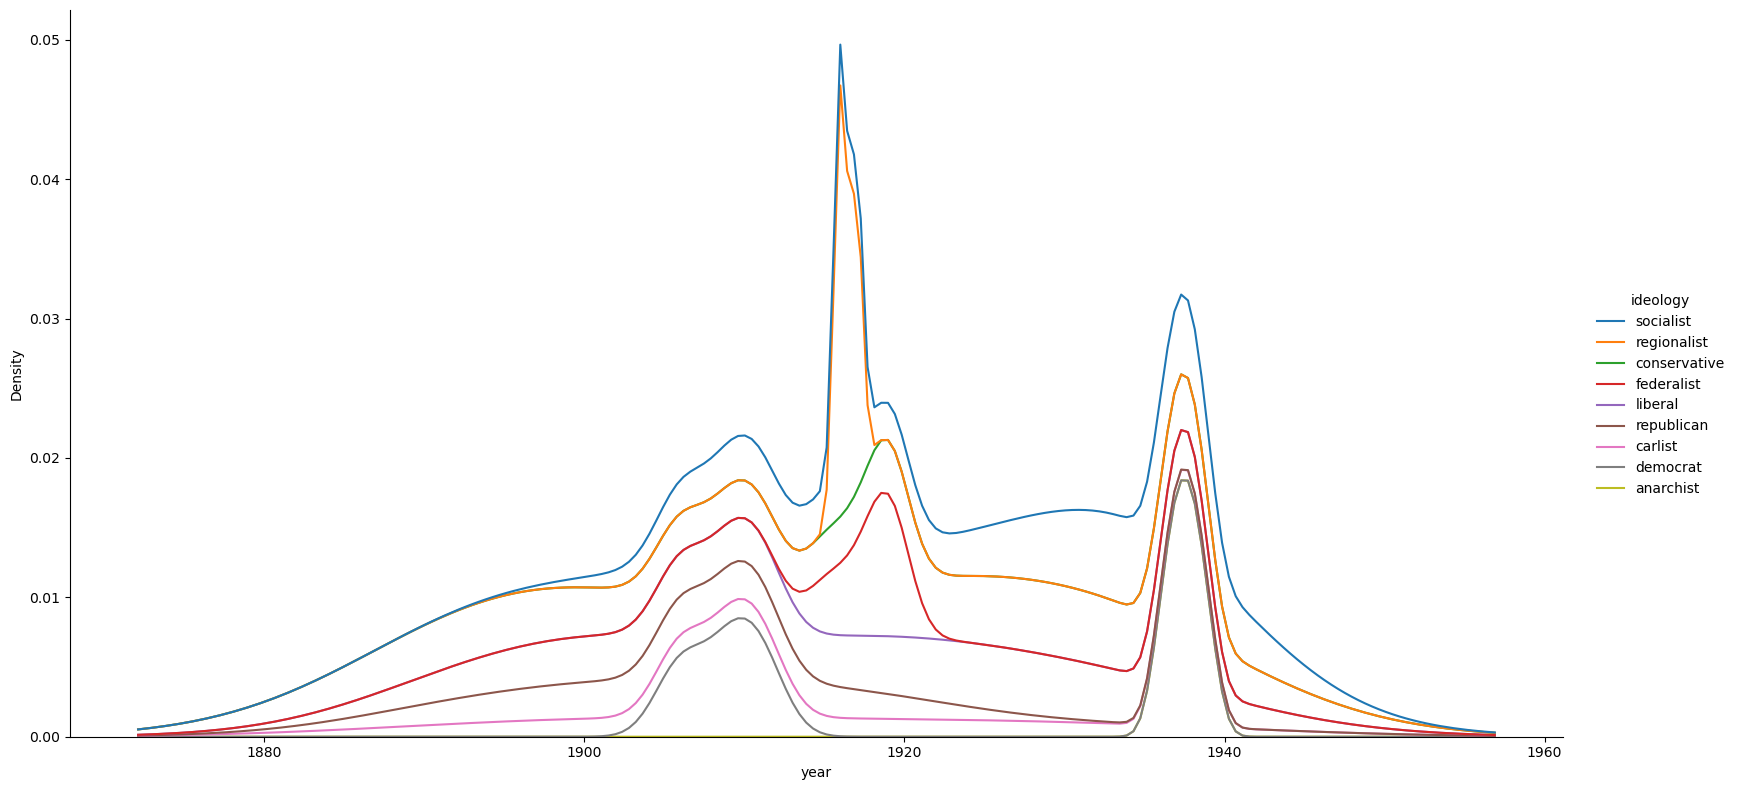

In [35]:
ax = sns.displot(df, x='year', hue='ideology', kind="kde",multiple="stack", height=8,aspect=2, fill=False)

The following graph shows the point presence of each ideology in a given period.

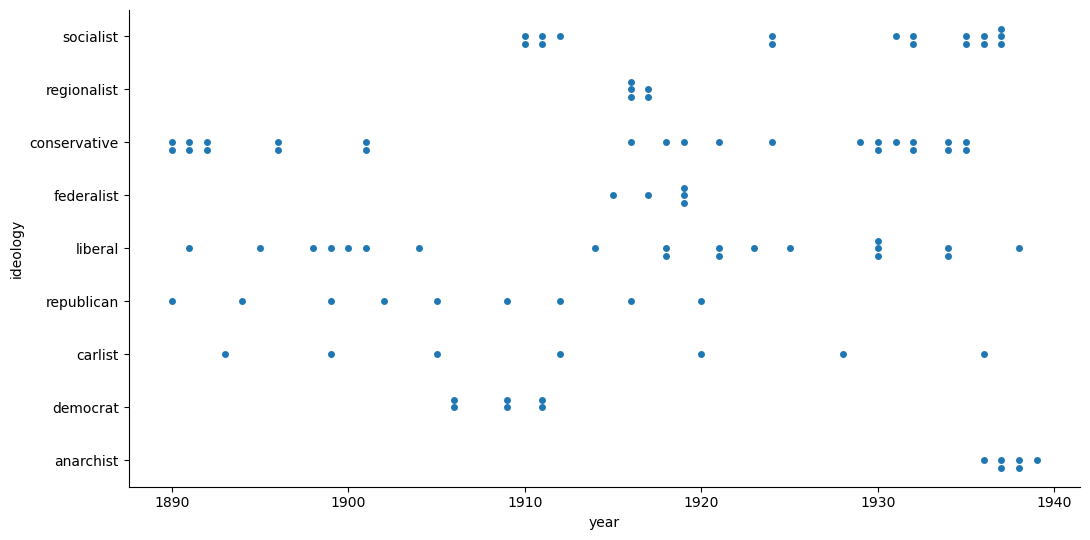

In [37]:
sns.catplot(data=df, x="year", y="ideology", height=5.5,aspect=2, kind="swarm")

The below boxplot depicts the representation of editions' format through the years.

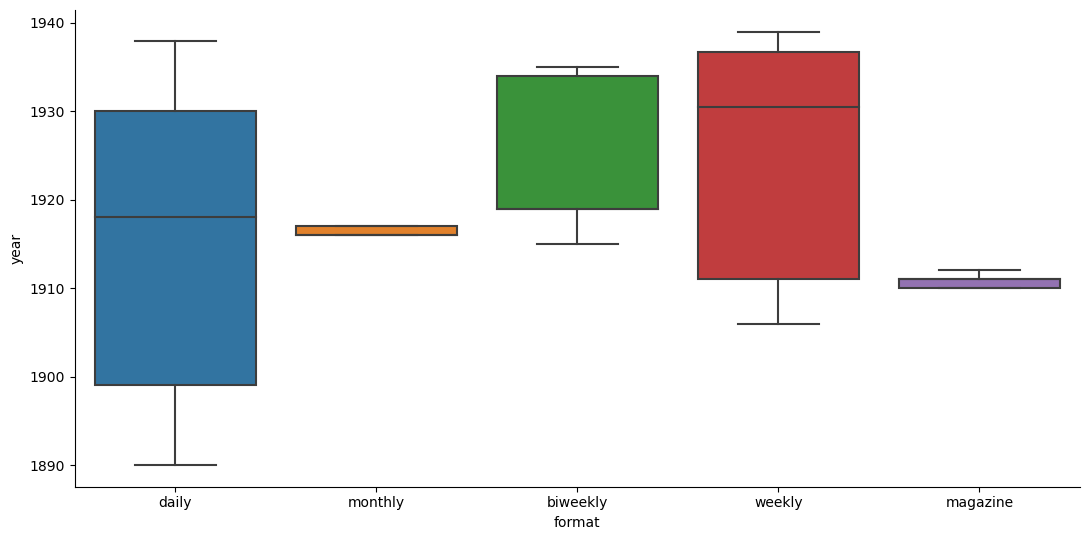

In [38]:
sns.catplot(data=df, x="format", y="year",  height=5.5,aspect=2, kind="box")

This second boxplot explains of audience types' coverage.

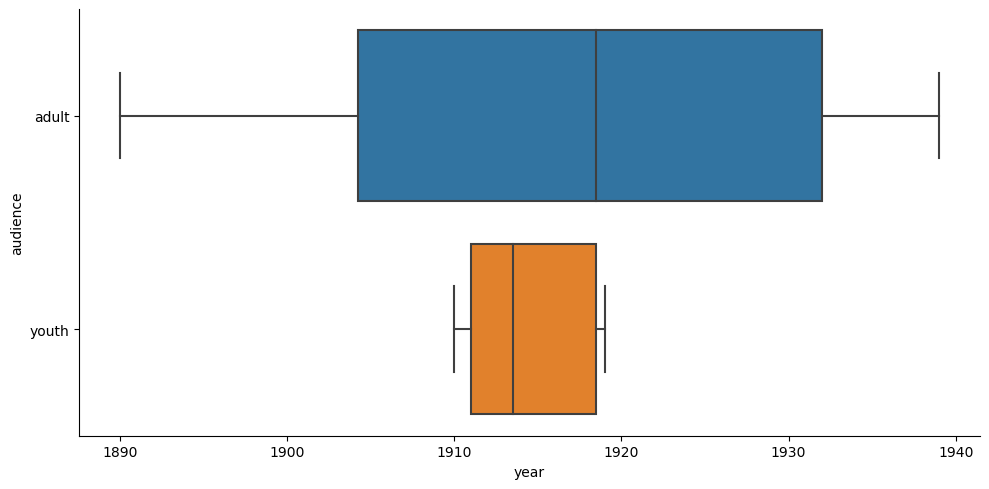

In [39]:
sns.catplot(data=df, x="year", y="audience",height=5,aspect=2, kind="box")

And, we also can determine the distribution of publications on a regional basis.

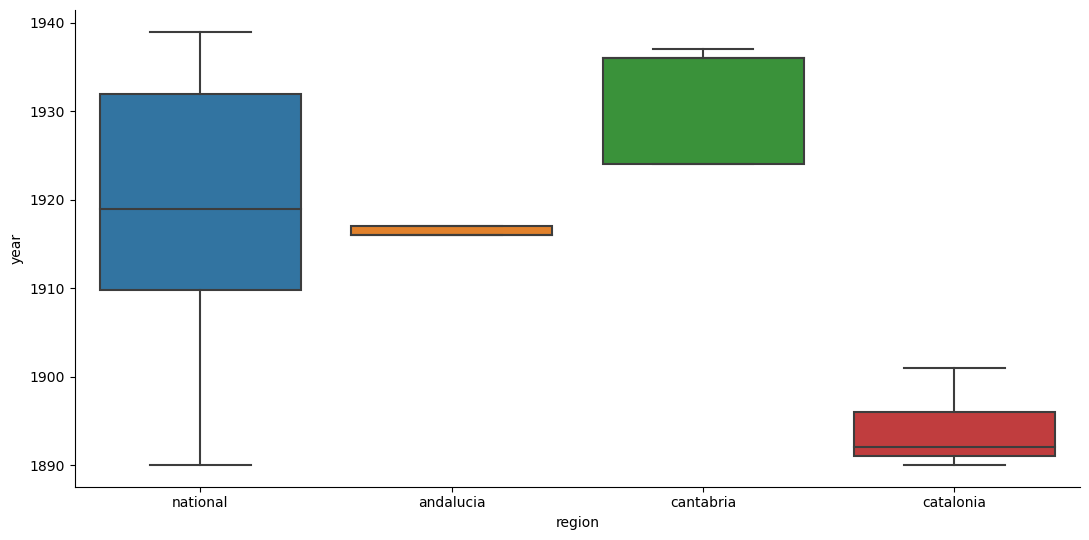

In [40]:
sns.catplot(data=df, x="region", y="year",  height=5.5,aspect=2, kind="box")

Similar observations can be made when analysing the ideological distribution of individual publications.

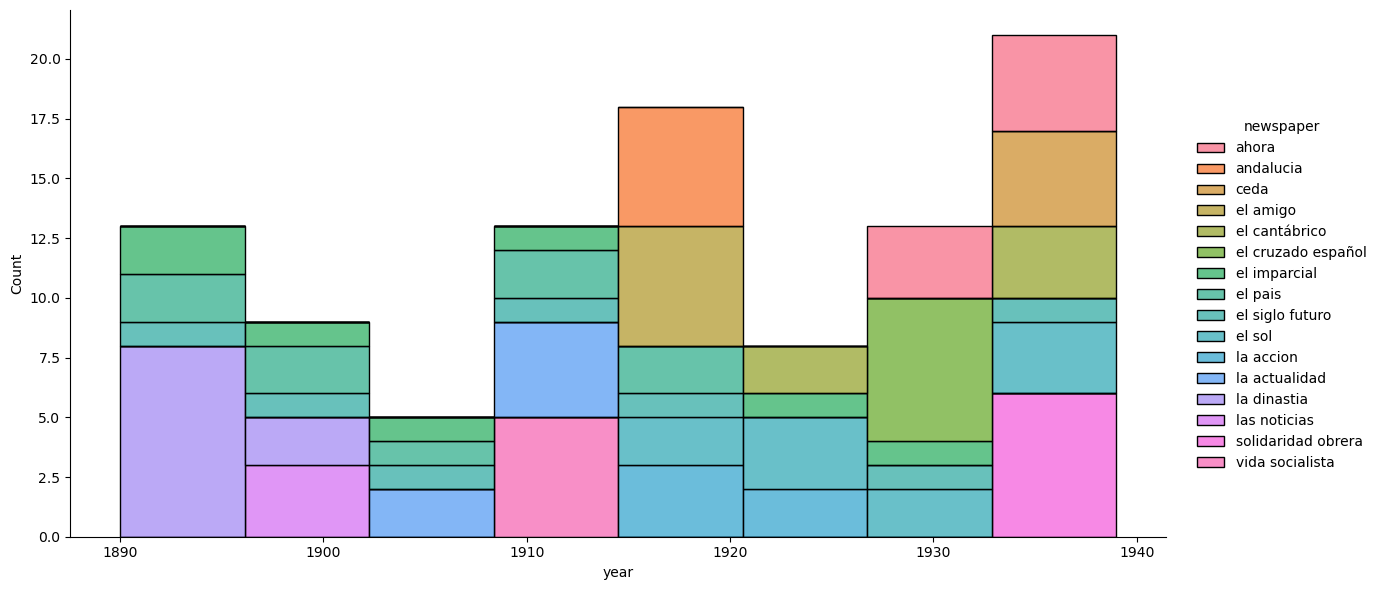

In [41]:
sns.displot(df, x ="year",hue='newspaper', height=6,aspect=2, multiple='stack')

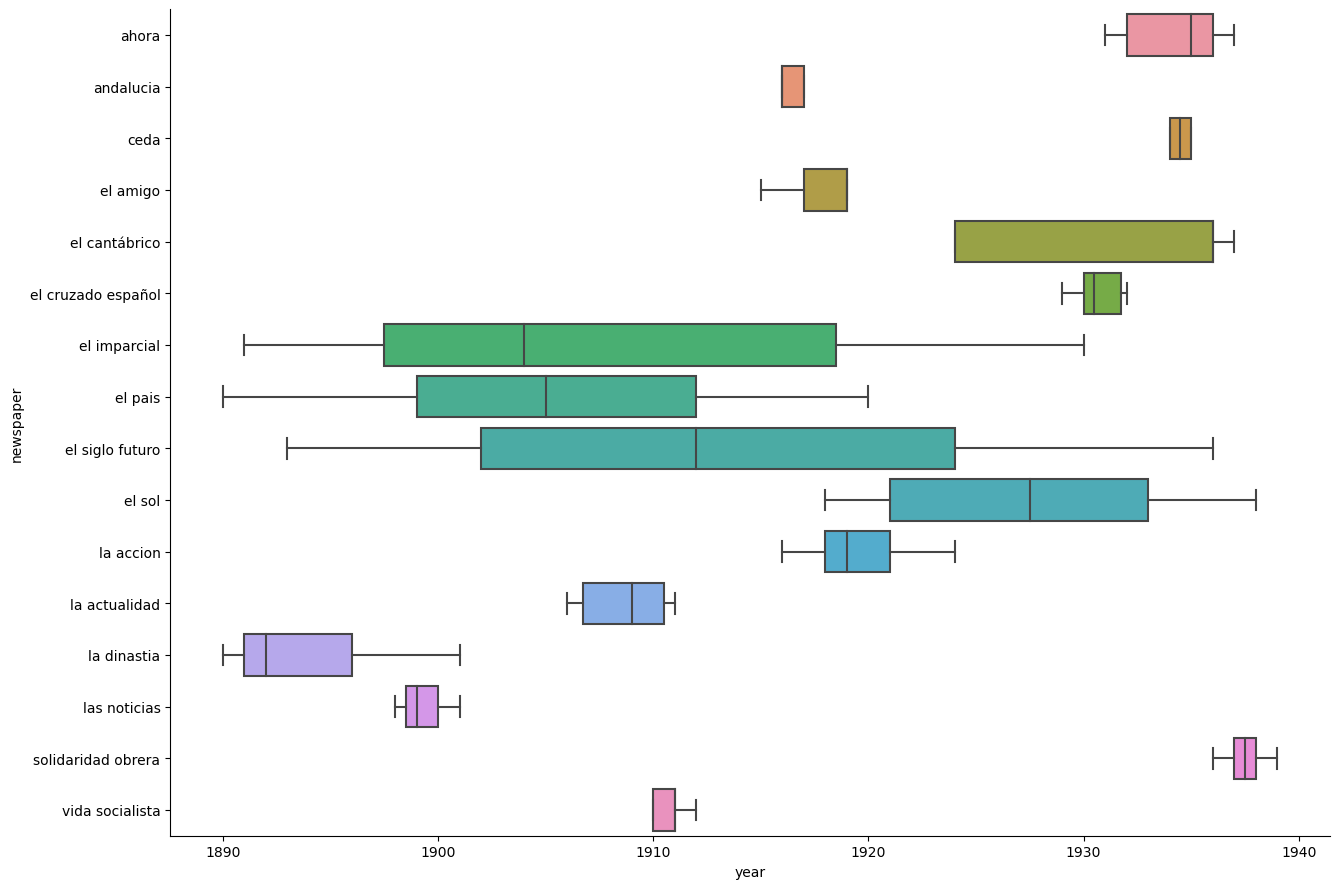

In [42]:
sns.catplot(data=df, x="year", y="newspaper", height=9,aspect=1.5, kind="box")

## Active Learning Exercises

The dataset containing information about Spanish newspapers from 1890 to 1940 not only deserves a contribution to be expanded and continuously updated but also allows tools such as Stylo and Gephi to be used to draw interesting observations. <br>
<br> Above in the Tutorial section you may find what we have created so far, now it is your turn. 

### Update the DataFrames

Given the breadth of resources there is the possibility to update the newspapers data with more newspapers editions, and possibly adding columns with additional information useful to understand Spanish journalistic culture (i.e. name of the journalists). At the moment, there does not seem to be the possibility of downloading the web page via html, but if they were to change the structure, the process of downloading the various editions could be automated. <br>
<br> Download from the __[Hemeroteca Digital](https://hemerotecadigital.bne.es/hd/es/advanced)__ other newspaper editions, clean them up using python and add related information to the DataFrame.

In [16]:
# Your code

### Explore the DataFrames

We decided to work with separate datasets because we figured it was tidier this way, but to better visualise all the data you might want to have a unique dataset with all the information. We have created one for you called editions_text_hq, resulted from the merging of the main DataFrame editions_with_text and some columns of the newspapers one that reports the information about the headquarters of the newspapers.

In [9]:
editions_text_hq = editions_with_text.merge(pd.DataFrame(newspapers[['newspaper', 'hq latitude', 'hq longitude',\
                                                                     'foundedin']]), on='newspaper')

Time to create interesting data visualisations! The task is yours, be creative. As an inspiration: how many sample for each ideology? Is there one you should amend by adding samples? 

In [160]:
# Your code

### Come up with interesting research questions

Being that this dataset lends itself well to the use of tools such as Stylo and Gephi, one might come in touch with interesting discoveries in the changing of writing styles over time or ideologies (i.e. Which factor influences the style of a newspaper the most? Can you think of other features to add to the dataset?). To do so, we advise you to rename the files each time with the feature you want to investigate, like this: ideology_id, audience_id etc. 

In [8]:
# Your code